# MobiML GeoTrackNet Demo

Based on: https://github.com/CIA-Oceanix/GeoTrackNet (MIT Licensed, (c) 2018 Duong Nguyen)

As presented in Nguyen, D., Vadaine, R., Hajduch, G., Garello, R. (2022). GeoTrackNet - A Maritime Anomaly Detector Using Probabilistic Neural Network Representation of AIS Tracks and A Contrario Detection. In IEEE Transactions on Intelligent Transportation Systems, 23(6).


Using data from AISDK: http://web.ais.dk/aisdata/aisdk-2018-02.zip

*It is possible to further explore maritime traffic patterns with the TrAISformer (https://github.com/CIA-Oceanix/TrAISformer), which is used for vessel trajectory prediction. The TrAISformer can be trained with AIS data and the preprocessing steps are similar to those of GeoTrackNet. However, the TrAISformer is out of the scope of MobiML and is an optional extension for the user to explore.*

## Environments

### Preprocessing

It is recommended to perform the preprocessing steps with the MobiML environment.

### Model Training

Set up a dedicated GeoTrackNet environment (PY3GPU) to train the model as instructed by Nguyen et al. (2022).

## Preprocessing

In [1]:
import numpy as np
import os
import sys
import pickle
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
from datetime import datetime, timedelta

sys.path.append("..")
from mobiml.datasets import AISDK
from mobiml.preprocessing import (
    TrajectorySplitter,
    TrajectoryFilter,
    TrajectorySubsampler,
)
from mobiml.transforms import TemporalSplitter

/home/anita/miniforge3/envs/mobiml/lib/python3.10/site-packages/movingpandas/__init__.py:37: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)
/home/anita/miniforge3/envs/mobiml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pwd

'/home/anita/Documents/Github/mobiml/examples'

In [3]:
# AISDK dataset
LAT, LON, SOG, COG, NAME, SHIPTYPE, NAV_STT, TIMESTAMP, TRAJ_ID = list(range(9))

EPOCH = datetime(1970, 1, 1)

SOG_MIN = 2.0
SOG_MAX = 30.0  # SOG is truncated to 30.0 knots max

# Pkl filenames
pkl_filename_train = "aisdk_20180208_train.pkl"
pkl_filename_valid = "aisdk_20180208_valid.pkl"
pkl_filename_test = "aisdk_20180208_test.pkl"

# Path to csv files
data_path = "data/aisdk_20180208_sample/"
csv_filename = "aisdk_20180208_sample.csv"

# Output path
out_path = "data/aisdk_20180208_sample/"

### Loading data

In [4]:
path = os.path.join(data_path, csv_filename)
print(f"{datetime.now()} Loading data from {path}")
aisdk = AISDK(path)  # you can specify a bounding box here to filter the area
LON_MIN, LAT_MIN, LON_MAX, LAT_MAX = aisdk.get_bounds()
print(
    f"Bounding box:\nmin_lon: {LON_MIN}\nmin_lat: {LAT_MIN}\nmax_lon: {LON_MAX}\nmax_lat: {LAT_MAX}"
)

2024-10-22 22:10:30.785165 Loading data from data/aisdk_20180208_sample/aisdk_20180208_sample.csv
2024-10-22 22:10:32.524538 Loaded Dataframe with 280849 rows.
Bounding box:
min_lon: 11.3
min_lat: 57.4
max_lon: 12.013717
max_lat: 57.9


### Cleaning

#### Remove missing values

In [5]:
aisdk.df = aisdk.df.dropna()
aisdk.df

,traj_id,y,x,nav_status,speed,direction,Name,ship_type,mover_id,timestamp
264,636016188,57.667933,11.799392,At anchor,0.1,172.5,LPG/C ODERGAS,Tanker,636016188,2018-02-08 00:00:44
294,266150000,57.676467,11.714417,Under way using engine,9.2,95.0,SANDEFJORD,Fishing,266150000,2018-02-08 00:00:48
369,265547240,57.633283,11.816162,Under way using engine,17.2,189.5,VIPAN,Passenger,265547240,2018-02-08 00:01:00
387,266150000,57.676400,11.716017,Under way using engine,9.3,94.0,SANDEFJORD,Fishing,266150000,2018-02-08 00:01:03
388,265547240,57.632497,11.815928,Under way using engine,17.2,188.4,VIPAN,Passenger,265547240,2018-02-08 00:01:03
...,...,...,...,...,...,...,...,...,...,...
550177,266128000,57.677663,11.755688,Unknown value,8.9,265.3,CLINTON,Fishing,266128000,2018-02-08 23:59:57
550178,219945000,57.745767,11.341833,Under way using engine,16.5,157.1,PEARL SEAWAYS,Passenger,219945000,2018-02-08 23:59:58
550180,265760070,57.689763,11.873632,Under way using engine,1.7,79.9,NORTHERN KATTEGAT,Tanker,265760070,2018-02-08 23:59:58
550185,265177000,57.601653,11.640610,Under way using engine,16.1,69.4,STENA DANICA,Passenger,265177000,2018-02-08 23:59:58


In [6]:
print("After removing missing values we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])
print("Total number of vessels:", len(aisdk.df.traj_id.unique()))
print("Lat min: ", aisdk.df.y.min(), "Lat max: ", aisdk.df.y.max())
print("Lon min: ", aisdk.df.x.min(), "Lon max: ", aisdk.df.x.max())
print("Time min: ", aisdk.df.timestamp.min(), "Time max: ", aisdk.df.timestamp.max())

After removing missing values we have...
Total number of AIS messages:  279064
Total number of vessels: 243
Lat min:  57.4 Lat max:  57.9
Lon min:  11.3 Lon max:  12.013717
Time min:  2018-02-08 00:00:44 Time max:  2018-02-08 23:59:58


#### Remove 'Moored' and 'At anchor' AIS messages

In [7]:
aisdk.df.drop(aisdk.df[(aisdk.df["nav_status"] == "Moored") | (aisdk.df["nav_status"] == "At anchor")].index, inplace=True)
print("After removing 'Moored' or 'At anchor' AIS messages we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

After removing 'Moored' or 'At anchor' AIS messages we have...
Total number of AIS messages:  273447


#### Keep only 'Cargo', 'Tanker', 'Passenger' vessel types

In [8]:
aisdk.df = aisdk.df[
    (aisdk.df["ship_type"] == "Cargo")
    | (aisdk.df["ship_type"] == "Tanker")
    | (aisdk.df["ship_type"] == "Passenger")
]
print("After keeping only 'Cargo', 'Tanker' or 'Passenger' AIS messages we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

After keeping only 'Cargo', 'Tanker' or 'Passenger' AIS messages we have...
Total number of AIS messages:  191197


#### Split trajectories with observation gaps > 2 hrs

In [9]:
aisdk = TrajectorySplitter(aisdk).split(observation_gap=timedelta(hours=2))
print("After splitting trajectories with observation gaps we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

After splitting trajectories with observation gaps we have...
Total number of AIS messages:  188118


#### Drop trajectories with fewer than $Points_{min}$ locations

In [10]:
aisdk = TrajectoryFilter(aisdk).filter_min_pts(min_pts=20)
print("After removing trajectories with too few points we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

After removing trajectories with too few points we have...
Total number of AIS messages:  188037


#### Drop speed outliers

In [11]:
aisdk = TrajectoryFilter(aisdk).filter_speed(min_speed=SOG_MIN, max_speed=SOG_MAX)
print("After removing speed outliers by setting a minimum and maximum speed we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

After removing speed outliers by setting a minimum and maximum speed we have...
Total number of AIS messages:  163051


In [12]:
tc = aisdk.to_trajs() #  mpd.TrajectoryCollection(aisdk.df, "traj_id", t="timestamp", x="x", y="y")
traj_gdf = tc.to_traj_gdf()

We may also want to remove trajectories based on their overall average speed rather than the SOG values:

In [13]:
for index, row in traj_gdf.iterrows():
    traj_gdf.loc[index, "speed_ok"] = (
        tc.trajectories[index].get_length()
        / tc.trajectories[index].get_duration().total_seconds()
        > 1.02889  # 2 knots
    )

In [14]:
traj_gdf = traj_gdf[traj_gdf["speed_ok"] == True]

In [15]:
aisdk.df = pd.merge(aisdk.df, traj_gdf["traj_id"], how="inner")
print("After removing speed outliers based on length and duration we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

After removing speed outliers based on length and duration we have...
Total number of AIS messages:  161336


### Training data preparation
#### Subsample AIS tracks 

In [16]:
aisdk = TrajectorySubsampler(aisdk).subsample(min_dt_sec=60)
print("After subsampling AIS tracks we have...")
print("Total number of AIS messages: ", aisdk.df.shape[0])

100%|██████████| 185/185 [00:00<00:00, 837.62it/s]

After subsampling AIS tracks we have...
Total number of AIS messages:  20623


#### Temporal train/valid/test split

In [17]:
aisdk = TemporalSplitter(aisdk).split_hr()
aisdk.df

2024-10-22 22:11:39.705099 Splitting dataset by hours ...
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dev: [16, 17, 18, 19, 20], test: [21, 22, 23]
Train @(min(train_hr), max(train_hr))=(0, 15), 
Dev @(min(dev_hr), max(dev_hr))=(16, 20), 
Test @(min(test_hr), max(test_hr))=(21, 23)


,traj_id,nav_status,speed,direction,Name,ship_type,mover_id,x,y,timestamp,split
0,209487000_0,Under way using engine,10.5,339.5,FRI LANGESUND,Cargo,209487000,11.485500,57.400133,2018-02-08 17:12:29,2.0
6,209487000_0,Under way using engine,10.5,340.9,FRI LANGESUND,Cargo,209487000,11.483767,57.402883,2018-02-08 17:13:29,2.0
11,209487000_0,Under way using engine,10.5,341.0,FRI LANGESUND,Cargo,209487000,11.482017,57.405650,2018-02-08 17:14:29,2.0
16,209487000_0,Under way using engine,10.5,339.6,FRI LANGESUND,Cargo,209487000,11.480233,57.408417,2018-02-08 17:15:29,2.0
21,209487000_0,Under way using engine,10.5,340.4,FRI LANGESUND,Cargo,209487000,11.478483,57.411200,2018-02-08 17:16:29,2.0
...,...,...,...,...,...,...,...,...,...,...,...
161307,664288000_0,Under way using engine,12.7,315.0,SEYCHELLES PIONEER,Tanker,664288000,11.320740,57.521670,2018-02-08 10:49:58,1.0
161314,664288000_0,Under way using engine,12.7,315.3,SEYCHELLES PIONEER,Tanker,664288000,11.316168,57.524152,2018-02-08 10:50:58,1.0
161320,664288000_0,Under way using engine,12.7,314.8,SEYCHELLES PIONEER,Tanker,664288000,11.311517,57.526682,2018-02-08 10:51:58,1.0
161326,664288000_0,Under way using engine,12.7,314.9,SEYCHELLES PIONEER,Tanker,664288000,11.306948,57.529165,2018-02-08 10:52:58,1.0


In [18]:
aisdk_train = aisdk.df[(aisdk.df["split"] == 1.0)]
aisdk_valid = aisdk.df[(aisdk.df["split"] == 2.0)]
aisdk_test = aisdk.df[(aisdk.df["split"] == 3.0)]

print("Total number of AIS messages: ", len(aisdk.df))
print("Number of msgs in the training set: ", len(aisdk_train))
print("Number of msgs in the validation set: ", len(aisdk_valid))
print("Number of msgs in the test set: ", len(aisdk_test))

Total number of AIS messages:  20623
Number of msgs in the training set:  14108
Number of msgs in the validation set:  4473
Number of msgs in the test set:  2042


In [19]:
aisdk_train

,traj_id,nav_status,speed,direction,Name,ship_type,mover_id,x,y,timestamp,split
323,209506000_0,Under way using engine,9.4,114.0,ATLANTIC COMET,Cargo,209506000,11.300333,57.669167,2018-02-08 02:01:56,1.0
329,209506000_0,Under way using engine,9.4,114.0,ATLANTIC COMET,Cargo,209506000,11.304833,57.668167,2018-02-08 02:02:56,1.0
335,209506000_0,Under way using engine,9.5,113.0,ATLANTIC COMET,Cargo,209506000,11.309167,57.667167,2018-02-08 02:03:56,1.0
341,209506000_0,Under way using engine,9.8,113.0,ATLANTIC COMET,Cargo,209506000,11.313833,57.666167,2018-02-08 02:04:56,1.0
348,209506000_0,Under way using engine,10.3,114.0,ATLANTIC COMET,Cargo,209506000,11.318667,57.665000,2018-02-08 02:05:57,1.0
...,...,...,...,...,...,...,...,...,...,...,...
161307,664288000_0,Under way using engine,12.7,315.0,SEYCHELLES PIONEER,Tanker,664288000,11.320740,57.521670,2018-02-08 10:49:58,1.0
161314,664288000_0,Under way using engine,12.7,315.3,SEYCHELLES PIONEER,Tanker,664288000,11.316168,57.524152,2018-02-08 10:50:58,1.0
161320,664288000_0,Under way using engine,12.7,314.8,SEYCHELLES PIONEER,Tanker,664288000,11.311517,57.526682,2018-02-08 10:51:58,1.0
161326,664288000_0,Under way using engine,12.7,314.9,SEYCHELLES PIONEER,Tanker,664288000,11.306948,57.529165,2018-02-08 10:52:58,1.0


In [20]:
target_column_order=["y", "x", "speed", "direction", "Name", "ship_type", "nav_status", "timestamp", "traj_id"]
aisdk_train = aisdk_train[target_column_order].reset_index(drop=True)
aisdk_valid = aisdk_valid[target_column_order].reset_index(drop=True)
aisdk_test = aisdk_test[target_column_order].reset_index(drop=True)
aisdk_test

,y,x,speed,direction,Name,ship_type,nav_status,timestamp,traj_id
0,57.400250,11.573602,12.1,313.7,FORESTER,Cargo,Under way using engine,2018-02-08 21:42:31,211233870_1
1,57.402667,11.569027,12.3,315.1,FORESTER,Cargo,Under way using engine,2018-02-08 21:43:31,211233870_1
2,57.405042,11.564397,12.3,314.0,FORESTER,Cargo,Under way using engine,2018-02-08 21:44:31,211233870_1
3,57.407342,11.559877,12.3,313.4,FORESTER,Cargo,Under way using engine,2018-02-08 21:45:31,211233870_1
4,57.409697,11.555315,12.4,314.5,FORESTER,Cargo,Under way using engine,2018-02-08 21:46:31,211233870_1
...,...,...,...,...,...,...,...,...,...
2037,57.526500,11.322833,11.7,313.0,LAURA D,Cargo,Under way using engine,2018-02-08 22:56:13,636092722_0
2038,57.528667,11.318500,11.7,313.0,LAURA D,Cargo,Under way using engine,2018-02-08 22:57:13,636092722_0
2039,57.531333,11.313333,11.7,313.0,LAURA D,Cargo,Under way using engine,2018-02-08 22:58:23,636092722_0
2040,57.533500,11.309000,11.7,313.0,LAURA D,Cargo,Under way using engine,2018-02-08 22:59:23,636092722_0


#### Format timestamp

In [21]:
aisdk_train["timestamp"] = (aisdk_train["timestamp"].astype(int) / 1_000_000_000).astype(int)
aisdk_valid["timestamp"] = (aisdk_valid["timestamp"].astype(int) / 1_000_000_000).astype(int)
aisdk_test["timestamp"]  = (aisdk_test["timestamp"].astype(int) / 1_000_000_000).astype(int)
aisdk_test

,y,x,speed,direction,Name,ship_type,nav_status,timestamp,traj_id
0,57.400250,11.573602,12.1,313.7,FORESTER,Cargo,Under way using engine,1518126151,211233870_1
1,57.402667,11.569027,12.3,315.1,FORESTER,Cargo,Under way using engine,1518126211,211233870_1
2,57.405042,11.564397,12.3,314.0,FORESTER,Cargo,Under way using engine,1518126271,211233870_1
3,57.407342,11.559877,12.3,313.4,FORESTER,Cargo,Under way using engine,1518126331,211233870_1
4,57.409697,11.555315,12.4,314.5,FORESTER,Cargo,Under way using engine,1518126391,211233870_1
...,...,...,...,...,...,...,...,...,...
2037,57.526500,11.322833,11.7,313.0,LAURA D,Cargo,Under way using engine,1518130573,636092722_0
2038,57.528667,11.318500,11.7,313.0,LAURA D,Cargo,Under way using engine,1518130633,636092722_0
2039,57.531333,11.313333,11.7,313.0,LAURA D,Cargo,Under way using engine,1518130703,636092722_0
2040,57.533500,11.309000,11.7,313.0,LAURA D,Cargo,Under way using engine,1518130763,636092722_0


#### Format to ndarrays

In [22]:
aisdk_train = np.array(aisdk_train)
aisdk_valid = np.array(aisdk_valid)
aisdk_test = np.array(aisdk_test)

#### Merging into dict
Creating AIS tracks from the list of AIS messages. Each AIS track is formatted by a dictionary.

In [23]:
print("Convert to dicts of vessel's tracks...")

def convert_tracks_to_dicts(tracks):
    d = dict()
    for v_msg in tqdm(tracks):
        mmsi = int(v_msg[TRAJ_ID])
        if not (mmsi in list(d.keys())):
            d[mmsi] = np.empty((0, 9))
        d[mmsi] = np.concatenate(
            (d[mmsi], np.expand_dims(v_msg[:9], 0)), axis=0
        )
    for key in tqdm(list(d.keys())):
        d[key] = np.array(
            sorted(d[key], key=lambda m_entry: m_entry[TIMESTAMP])
        )
    return d

Vs_train = convert_tracks_to_dicts(aisdk_train)
Vs_valid = convert_tracks_to_dicts(aisdk_valid)
Vs_test = convert_tracks_to_dicts(aisdk_test)

Convert to dicts of vessel's tracks...


100%|██████████| 36/36 [00:00<00:00, 39465.48it/s]


#### Normalisation

In [24]:
print("Normalising data ...")

def normalize(d):
    for k in tqdm(list(d.keys())):
        v = d[k]
        v[:, LAT] = (v[:, LAT] - LAT_MIN) / (LAT_MAX - LAT_MIN)
        v[:, LON] = (v[:, LON] - LON_MIN) / (LON_MAX - LON_MIN)
        v[:, SOG][v[:, SOG] > SOG_MAX] = SOG_MAX
        v[:, SOG] = v[:, SOG] / SOG_MAX
        v[:, COG] = v[:, COG] / 360.0
    return d 

Vs_train = normalize(Vs_train)
Vs_valid = normalize(Vs_valid)
Vs_test = normalize(Vs_test)

Normalising data ...


100%|██████████| 36/36 [00:00<00:00, 45466.71it/s]


In [25]:
for filename, filedict in zip(
    [pkl_filename_train, pkl_filename_valid, pkl_filename_test],
    [Vs_train, Vs_valid, Vs_test],
):
    print("Writing to", os.path.join(out_path, filename))
    with open(os.path.join(out_path, filename), "wb") as f:
        pickle.dump(filedict, f)

Writing to data/aisdk_20180208_sample/aisdk_20180208_train.pkl
Writing to data/aisdk_20180208_sample/aisdk_20180208_valid.pkl
Writing to data/aisdk_20180208_sample/aisdk_20180208_test.pkl


## Model Training

From this point forward, it is recommended to execute the code with the [PY3GPU environment](https://github.com/CIA-Oceanix/GeoTrackNet/blob/master/requirements.yml), as set up by Nguyen et al. (2022).

### Setup

In [1]:
import os

# AISDK dataset
LAT, LON, SOG, COG, NAME, SHIPTYPE, NAV_STT, TIMESTAMP, TRAJ_ID = list(range(9))

# Pkl filenames
pkl_filename_train = "aisdk_20180208_train.pkl"
pkl_filename_valid = "aisdk_20180208_valid.pkl"
pkl_filename_test = "aisdk_20180208_test.pkl"

data_path = "../examples/data/aisdk_20180208_sample/"
dataset_path = os.path.join(data_path, pkl_filename_train)

### Calculate AIS mean

In [2]:
import numpy as np
import pickle
import tensorflow as tf

LAT_BINS = 100
LON_BINS = 200
SOG_BINS = 30
COG_BINS = 72


def sparse_AIS_to_dense(msgs_, num_timesteps, mmsis):
    def create_dense_vect(msg, lat_bins=100, lon_bins=200, sog_bins=30, cog_bins=72):
        lat, lon, sog, cog = msg[0], msg[1], msg[2], msg[3]
        data_dim = lat_bins + lon_bins + sog_bins + cog_bins
        dense_vect = np.zeros(data_dim)
        dense_vect[int(lat * lat_bins)] = 1.0
        dense_vect[int(lon * lon_bins) + lat_bins] = 1.0
        dense_vect[int(sog * sog_bins) + lat_bins + lon_bins] = 1.0
        dense_vect[int(cog * cog_bins) + lat_bins + lon_bins + sog_bins] = 1.0
        return dense_vect

    dense_msgs = []
    for msg in msgs_:
        dense_msgs.append(
            create_dense_vect(
                msg,
                lat_bins=LAT_BINS,
                lon_bins=LON_BINS,
                sog_bins=SOG_BINS,
                cog_bins=COG_BINS,
            )
        )
    dense_msgs = np.array(dense_msgs)
    return dense_msgs, num_timesteps, mmsis


dirname = os.path.dirname(dataset_path)

try:
    with tf.gfile.Open(dataset_path, "rb") as f:
        Vs = pickle.load(f)
except:
    with tf.gfile.Open(dataset_path, "rb") as f:
        Vs = pickle.load(f, encoding="latin1")

data_dim = LAT_BINS + LON_BINS + SOG_BINS + COG_BINS

mean_all = np.zeros((data_dim,))
sum_all = np.zeros((data_dim,))
total_ais_msg = 0

current_mean = np.zeros((0, data_dim))
current_ais_msg = 0

count = 0
for mmsi in list(Vs.keys()):
    count += 1
    print(count)
    tmp = Vs[mmsi][:, [LAT, LON, SOG, COG]]
    tmp[tmp == 1] = 0.99999
    current_sparse_matrix, _, _ = sparse_AIS_to_dense(tmp, 0, 0)
    #    current_mean = np.mean(current_sparse_matrix,axis = 0)
    sum_all += np.sum(current_sparse_matrix, axis=0)
    total_ais_msg += len(current_sparse_matrix)

mean = sum_all / total_ais_msg

print("Writing to", os.path.join(dirname, "/mean.pkl"))
with open(dirname + "/mean.pkl", "wb") as f:
    pickle.dump(mean, f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
Writing to /mean.pkl


### Training

#### Step 1: Training the Embedding layer

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import logging
import tensorflow as tf

import sys
sys.path.append("..")
import mobiml.models.geotracknet.runners as runners
from mobiml.models.geotracknet.flags_config import config

print(config.trainingset_path)
fh = logging.FileHandler(os.path.join(config.logdir, config.log_filename + ".log"))
tf.logging.set_verbosity(tf.logging.INFO)
# get TF logger
logger = logging.getLogger("tensorflow")
logger.addHandler(fh)
runners.run_train(config)

/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() o

Training set: ../examples/data/aisdk_20180208_sample/aisdk_20180208_train.pkl
Test set: ../examples/data/aisdk_20180208_sample/aisdk_20180208_train.pkl
../examples/data/aisdk_20180208_sample/aisdk_20180208_train.pkl
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./chkpt/elbo-aisdk_20180208_train.pkl-data_dim-402-latent_size-100-batch_size-32/model.ckpt-1006
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1006 into ./chkpt/elbo-aisdk_20180208_train.pkl-data_dim-402-latent_size-100-batch_size-32/model.ckpt.
INFO:tensorflow:Step 1007, elbo bound per timestep: -11.012907
INFO:tensorflow:Saving checkpoints for 1007 into ./chkpt/elbo-aisdk_20180208_train.pkl-data_dim-402-latent_size-100-batch_size-32/model.ckpt.


#### Step 2: Running task-specific submodels

In [2]:
import glob
import pickle

with open(config.testset_path, "rb") as f:
    Vs_test = pickle.load(f)
dataset_size = len(Vs_test)


In [3]:
step = None

tf.Graph().as_default()
global_step = tf.train.get_or_create_global_step()
inputs, targets, mmsis, time_starts, time_ends, lengths, model = (
    runners.create_dataset_and_model(config, shuffle=False, repeat=False)
)

if config.mode == "traj_reconstruction":
    config.missing_data = True

track_sample, track_true, log_weights, ll_per_t, ll_acc, _, _, _ = (
    runners.create_eval_graph(inputs, targets, lengths, model, config)
)
saver = tf.train.Saver()
sess = tf.train.SingularMonitoredSession()
runners.wait_for_checkpoint(saver, sess, config.logdir)
step = sess.run(global_step)

if step is None:
    # The log filename contains the step.
    index_filename = sorted(glob.glob(config.logdir+"/*.index"))[-1] # the lastest step
    step = int(index_filename.split(".index")[0].split("ckpt-")[-1])
    

print("Global step: ", step)
outputs_path = "results/"\
            + config.trainingset_path.split("/")[-2] + "/"\
            + "logprob-"\
            + os.path.basename(config.trainingset_name) + "-"\
            + os.path.basename(config.testset_name) + "-"\
            + str(config.latent_size)\
            + "-missing_data-" + str(config.missing_data)\
            + "-step-"+str(step)\
            + ".pkl"
if not os.path.exists(os.path.dirname(outputs_path)):
    os.makedirs(os.path.dirname(outputs_path))

save_dir = "results/"\
            + config.trainingset_path.split("/")[-2] + "/"\
            + "local_logprob-"\
            + os.path.basename(config.trainingset_name) + "-"\
            + os.path.basename(config.testset_name).replace("test","valid") + "-"\
            + str(config.latent_size) + "-"\
            + "missing_data-" + str(config.missing_data)\
            + "-step-"+str(step)\
            +"/"     

/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() o

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Restoring parameters from ./chkpt/elbo-aisdk_20180208_train.pkl-data_dim-402-latent_size-100-batch_size-32/model.ckpt-1007
Global step:  1007


##### save_logprob

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
FIG_DPI = 150

l_dict = []
for d_i in tqdm(list(range(math.ceil(dataset_size / config.batch_size)))):
    inp, tar, mmsi, t_start, t_end, seq_len, log_weights_np, true_np, ll_t = (
        sess.run(
            [
                inputs,
                targets,
                mmsis,
                time_starts,
                time_ends,
                lengths,
                log_weights,
                track_true,
                ll_per_t,
            ]
        )
    )
    for d_idx_inbatch in range(inp.shape[1]):
        D = dict()
        seq_len_d = seq_len[d_idx_inbatch]
        D["seq"] = np.nonzero(tar[:seq_len_d, d_idx_inbatch, :])[1].reshape(-1, 4)
        D["t_start"] = t_start[d_idx_inbatch]
        D["t_end"] = t_end[d_idx_inbatch]
        D["mmsi"] = mmsi[d_idx_inbatch]
        D["log_weights"] = log_weights_np[:seq_len_d, :, d_idx_inbatch]
        l_dict.append(D)
with open(outputs_path, "wb") as f:
    pickle.dump(l_dict, f)

v_logprob = np.empty((0,))
v_logprob_stable = np.empty((0,))

count = 0
for D in tqdm(l_dict):
    log_weights_np = D["log_weights"]
    ll_t = np.mean(log_weights_np)
    v_logprob = np.concatenate((v_logprob, [ll_t]))

d_mean = np.mean(v_logprob)
d_std = np.std(v_logprob)
d_thresh = d_mean - 3 * d_std

plt.figure(figsize=(1920/FIG_DPI, 640/FIG_DPI), dpi=FIG_DPI)
plt.plot(v_logprob,'o')
plt.title("Log likelihood " + os.path.basename(config.testset_name)\
            + ", mean = {0:02f}, std = {1:02f}, threshold = {2:02f}".format(d_mean, d_std, d_thresh))
plt.plot([0,len(v_logprob)], [d_thresh, d_thresh],'r')

plt.xlim([0,len(v_logprob)])
fig_name = "results/"\
        + config.trainingset_path.split("/")[-2] + "/" \
        + "logprob-" \
        + config.bound + "-"\
        + os.path.basename(config.trainingset_name) + "-"\
        + os.path.basename(config.testset_name)\
        + "-latent_size-" + str(config.latent_size)\
        + "-ll_thresh" + str(round(d_thresh, 2))\
        + "-missing_data-" + str(config.missing_data)\
        + "-step-"+str(step)\
        + ".png"
plt.savefig(fig_name,dpi = FIG_DPI)
plt.close()

100%|██████████| 137/137 [00:00<00:00, 51697.67it/s]


![](fig_name)

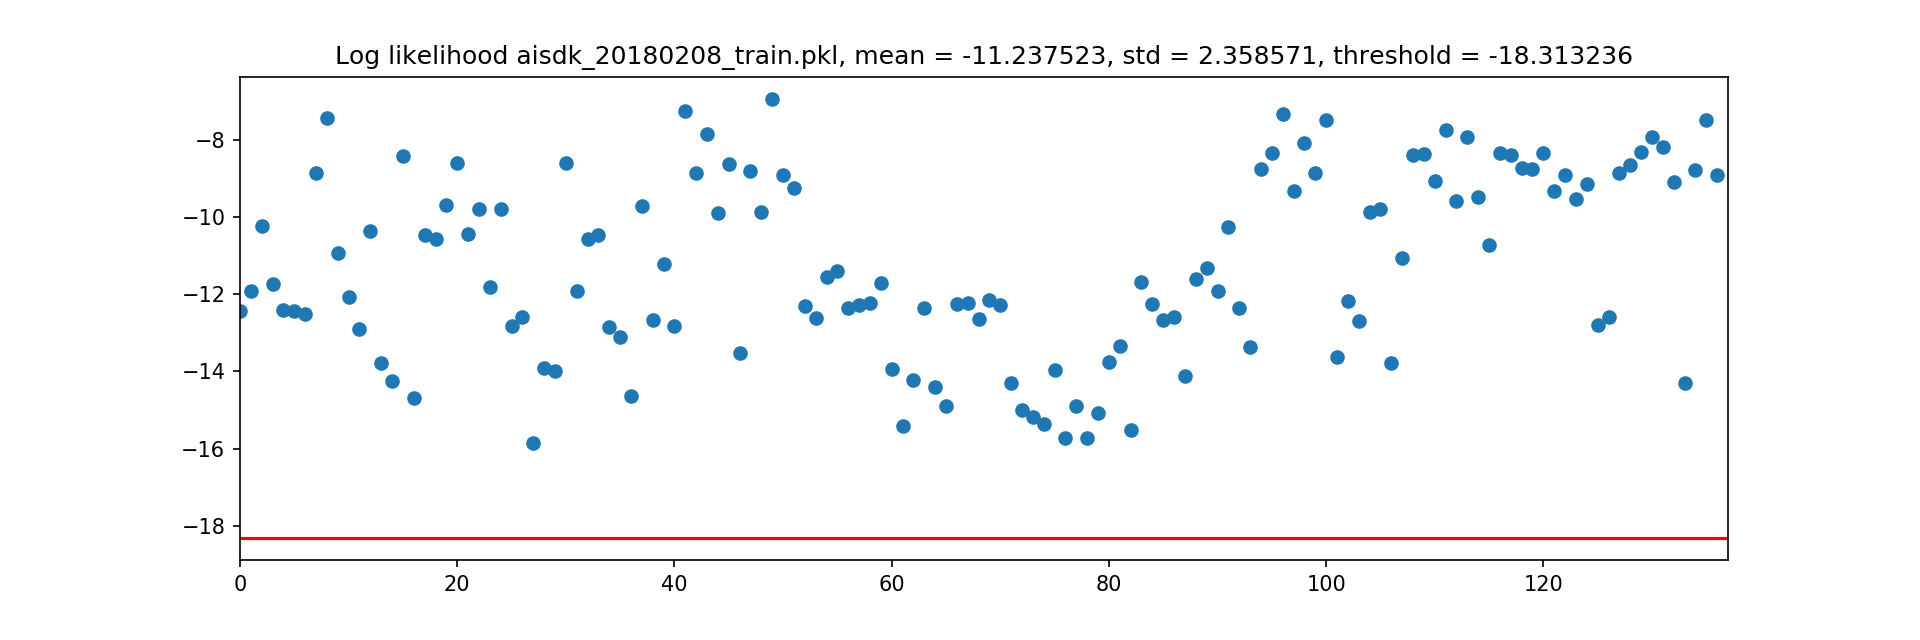

In [5]:
from IPython.display import Image
Image(filename=fig_name) 

##### local_logprob

In [6]:
import mobiml.models.geotracknet.utils as utils

LOGPROB_MEAN_MIN = -10.0
LOGPROB_STD_MAX = 5

LAT_RANGE = config.lat_max - config.lat_min
LON_RANGE = config.lon_max - config.lon_min
FIG_W = 960
FIG_H = int(FIG_W*LAT_RANGE/LON_RANGE)

m_map_logprob_std = np.zeros(shape=(config.n_lat_cells,config.n_lon_cells))
m_map_logprob_mean = np.zeros(shape=(config.n_lat_cells,config.n_lon_cells))
m_map_density = np.zeros(shape=(config.n_lat_cells,config.n_lon_cells))
v_logprob = np.empty((0,))
v_mmsi = np.empty((0,))
Map_logprob = dict()
for row  in range(config.n_lat_cells):
    for col in range(config.n_lon_cells):
        Map_logprob[ str(str(row)+","+str(col))] = []

# Load logprob
with open(outputs_path,"rb") as f:
    l_dict = pickle.load(f)

print("Calculating the logprob map...")
for D in tqdm(l_dict):
    tmp = D["seq"]
    log_weights_np = D["log_weights"]
    for d_timestep in range(2*6,len(tmp)):
        try:
            row = int(tmp[d_timestep,0]*0.01/config.cell_lat_reso)
            col = int((tmp[d_timestep,1]-config.onehot_lat_bins)*0.01/config.cell_lat_reso)
            Map_logprob[str(row)+","+str(col)].append(np.mean(log_weights_np[d_timestep,:]))
        except:
            continue

# Remove outliers
for row  in range(config.n_lat_cells):
    for col in range(config.n_lon_cells):
        s_key = str(row)+","+str(col) 
        Map_logprob[s_key] = utils.remove_gaussian_outlier(np.array(Map_logprob[s_key]))
        m_map_logprob_mean[row,col] = np.mean(Map_logprob[s_key])
        m_map_logprob_std[row,col] = np.std(Map_logprob[s_key])
        m_map_density[row,col] = len(Map_logprob[s_key])

# Save to disk
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(save_dir+"map_density-"+str(config.cell_lat_reso)+"-"+str(config.cell_lon_reso),m_map_density)
with open(os.path.join(save_dir,"Map_logprob-"+str(config.cell_lat_reso)+"-"+str(config.cell_lon_reso)+".pkl"),"wb") as f:
    pickle.dump(Map_logprob,f)

# Show the map
utils.show_logprob_map(m_map_logprob_mean, m_map_logprob_std, save_dir, 
                        logprob_mean_min = LOGPROB_MEAN_MIN,
                        logprob_std_max = LOGPROB_STD_MAX,
                        fig_w = FIG_W, fig_h = FIG_H,
                        )    

print(f'Maps stored saved to: {os.path.join(save_dir, "logprob_std_map.png")}')

100%|██████████| 137/137 [00:00<00:00, 1088.83it/s]

Calculating the logprob map...



  ret = ret.dtype.type(ret / rcount)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/anita/miniforge3/envs/PY3GPU/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../mobiml/models/geotracknet/utils.py:280: RuntimeWarning: in

results/aisdk_20180208_sample/local_logprob-aisdk_20180208_train.pkl-aisdk_20180208_train.pkl-100-missing_data-False-step-1007/logprob_std_map.png
Maps stored saved to: results/aisdk_20180208_sample/local_logprob-aisdk_20180208_train.pkl-aisdk_20180208_train.pkl-100-missing_data-False-step-1007/logprob_std_map.png


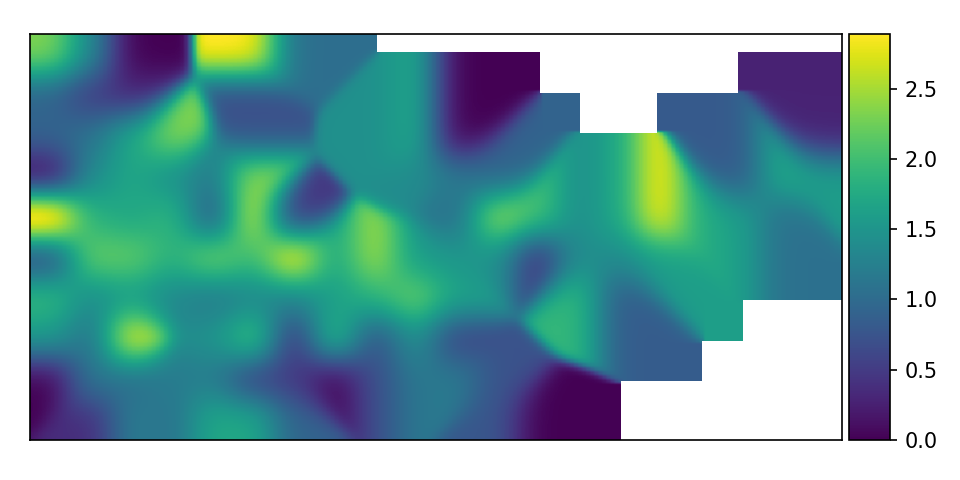

In [7]:
Image(filename=os.path.join(save_dir, "logprob_std_map.png")) 

##### contrario_detection

In [8]:
import csv
from scipy import stats
from datetime import datetime
import mobiml.models.geotracknet.contrario_utils as contrario_utils

with open(os.path.join(save_dir,"Map_logprob-"+\
            str(config.cell_lat_reso)+"-"+str(config.cell_lat_reso)+".pkl"),"rb") as f:
    Map_logprob = pickle.load(f)
# Load the logprob
with open(outputs_path,"rb") as f:
    l_dict = pickle.load(f)
d_i = 0
v_mean_log = []
l_v_A = []
v_buffer_count = []
length_track = len(l_dict[0]["seq"])
l_dict_anomaly = []
n_error = 0
for D in tqdm(l_dict):
    try:
    # if True:
        tmp = D["seq"]
        m_log_weights_np = D["log_weights"]
        v_A = np.zeros(len(tmp))
        for d_timestep in range(2*6,len(tmp)):
            d_row = int(tmp[d_timestep,0]*config.onehot_lat_reso/config.cell_lat_reso)
            d_col = int((tmp[d_timestep,1]-config.onehot_lat_bins)*config.onehot_lat_reso/config.cell_lon_reso)
            d_logprob_t = np.mean(m_log_weights_np[d_timestep,:])

            # KDE
            l_local_log_prod = Map_logprob[str(d_row)+","+str(d_col)]
            if len(l_local_log_prod) < 2:
                v_A[d_timestep] = 2
            else:
                kernel = stats.gaussian_kde(l_local_log_prod)
                cdf = kernel.integrate_box_1d(-np.inf,d_logprob_t)
                if cdf < 0.1:
                    v_A[d_timestep] = 1
        v_A = v_A[12:]
        v_anomalies = np.zeros(len(v_A))
        for d_i_4h in range(0,len(v_A)+1-24):
            v_A_4h = v_A[d_i_4h:d_i_4h+24]
            v_anomalies_i = contrario_utils.contrario_detection(v_A_4h,config.contrario_eps)
            v_anomalies[d_i_4h:d_i_4h+24][v_anomalies_i==1] = 1

        if len(contrario_utils.nonzero_segments(v_anomalies)) > 0:
            D["anomaly_idx"] = v_anomalies
            l_dict_anomaly.append(D)
    except:
        n_error += 1
print("Number of processed tracks: ",len(l_dict))
print("Number of abnormal tracks: ",len(l_dict_anomaly)) 
print("Number of errors: ",n_error)

# Save to disk
n_anomalies = len(l_dict_anomaly)
save_filename = os.path.basename(config.trainingset_name)\
                +"-" + os.path.basename(config.trainingset_name)\
                +"-" + str(config.latent_size)\
                +"-missing_data-"+str(config.missing_data)\
                +"-step-"+str(step)\
                +".pkl"
save_pkl_filename = os.path.join(save_dir,"List_abnormal_tracks-"+save_filename)
with open(save_pkl_filename,"wb") as f:
    pickle.dump(l_dict_anomaly,f)

## Plot
with open(config.trainingset_path,"rb") as f:
    Vs_train = pickle.load(f)
with open(config.testset_path,"rb") as f:
    Vs_test = pickle.load(f)

save_filename = "Abnormal_tracks"\
            + "-" + os.path.basename(config.trainingset_name)\
            + "-" + os.path.basename(config.testset_name)\
            + "-latent_size-" + str(config.latent_size)\
            + "-step-"+str(step)\
            + "-eps-"+str(config.contrario_eps)\
            + "-" + str(n_anomalies)\
            + ".png"

# Plot abnormal tracks with the tracks in the training set as the background
utils.plot_abnormal_tracks(Vs_train,l_dict_anomaly,
                    os.path.join(save_dir,save_filename),
                    config.lat_min,config.lat_max,config.lon_min,config.lon_max,
                    config.onehot_lat_bins,config.onehot_lon_bins,
                    background_cmap = "Blues",
                    fig_w = FIG_W, fig_h = FIG_H,
                )
plt.close()
# Plot abnormal tracks with the tracks in the test set as the background
utils.plot_abnormal_tracks(Vs_test,l_dict_anomaly,
                    os.path.join(save_dir,save_filename.replace("Abnormal_tracks","Abnormal_tracks2")),
                    config.lat_min,config.lat_max,config.lon_min,config.lon_max,
                    config.onehot_lat_bins,config.onehot_lon_bins,
                    background_cmap = "Greens",
                    fig_w = FIG_W, fig_h = FIG_H,
                )
plt.close()   
# Save abnormal tracks to csv file
with open(os.path.join(save_dir,save_filename.replace(".png",".csv")),"w") as f:
    writer = csv.writer(f)
    writer.writerow(["MMSI","Time_start","Time_end","Timestamp_start","Timestamp_end"])
    for D in l_dict_anomaly:
        writer.writerow([D["mmsi"],
            datetime.utcfromtimestamp(D["t_start"]).strftime('%Y-%m-%d %H:%M:%SZ'),
            datetime.utcfromtimestamp(D["t_end"]).strftime('%Y-%m-%d %H:%M:%SZ'),
            D["t_start"],D["t_end"]])
        
print(f'Maps stored saved to: {save_dir}')

100%|██████████| 137/137 [00:11<00:00, 11.74it/s]


Number of processed tracks:  137
Number of abnormal tracks:  1
Number of errors:  0
Maps stored saved to: results/aisdk_20180208_sample/local_logprob-aisdk_20180208_train.pkl-aisdk_20180208_train.pkl-100-missing_data-False-step-1007/


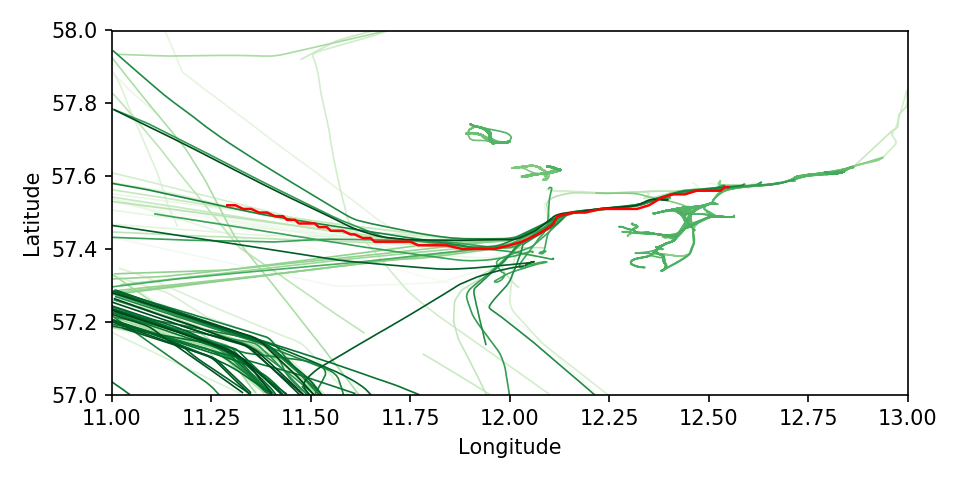

In [9]:
Image(filename=os.path.join(save_dir,save_filename.replace("Abnormal_tracks","Abnormal_tracks2"))) 